# Component inference and model families 

This notebook shows a series of examples of how to use model families and component inference with PCM.

In [1]:
# Import necessary libraries
import PcmPy as pcm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

## Simple 3 x 2 Anova
A classical example is a fully crossed design with two factors (A and B) and the possibility for an interaction between those two factors. 

#### Building a model family

In [2]:
# Generate the three model components, each one as a fixed model
M = []
A = np.array([[1.0,0,0],[1,0,0],[0,1,0],[0,1,0],[0,0,1],[0,0,1]])
B = np.array([[1.0,0],[0,1],[1,0],[0,1],[1,0],[0,1]])
M.append(pcm.FixedModel('A',A@A.T))
M.append(pcm.FixedModel('B',B@B.T))
M.append(pcm.FixedModel('I',np.eye(6)))
# Then construct a model family of all possible combinations 
MF=pcm.model.ModelFamily(M)

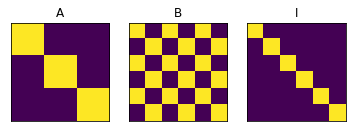

In [3]:
# Show the three model components
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    plt.imshow(M[i].G)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(M[i].name)

Note that no effort was made here to remove any of the overlap between the categories. That is, the interaction can explain all possible differences between stimuli, also differences that could be attributed to A and B. 

#### Generating data 

In [4]:
# Now generate 20 data set from the full model 
trueModel = MF[-1]
[cond_vec,part_vec]=pcm.sim.make_design(6,8)
D = pcm.sim.make_dataset(trueModel,np.array([-1.0,-1.0,-1.0]),
        signal=0.1,
        n_sim = 20,
        n_channel=20,part_vec=part_vec,
        cond_vec=cond_vec)
    

#### Fitting the data 
Now we can fit the data with the entire model family. An intercept is added as a fixed effect for each partition (block) seperately, as common for fMRI data. The result is a likelihood for each of the model combination. 

<AxesSubplot:xlabel='model', ylabel='Log Bayes Factor'>

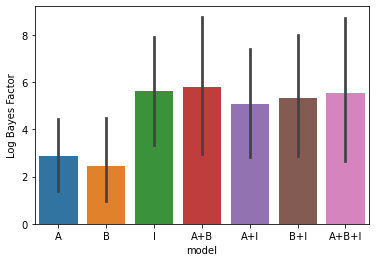

In [5]:
# Fit the data and display the relative likelihood. 
T,theta=pcm.fit_model_individ(D,MF,verbose=False,fixed_effect='block', fit_scale=False)
# Here we correcting for the number of parameters (using AIC)
pcm.vis.model_plot(T.likelihood-MF.num_comp_per_m)

#### Inference: Model posterior
For the inference, we can use either crossvalidated pseudo-likelihoods (within- subject or between subjects - see inference), or we can use the fitted likelihood, correcting for the number of paramaters using an AIC approach. We use latter approach here. 

ValueError: can only convert an array of size 1 to a Python scalar

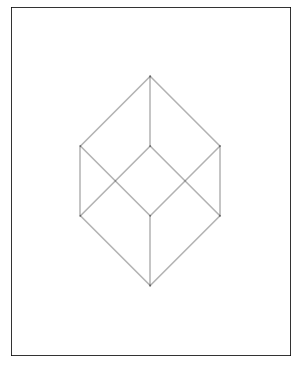

In [6]:
# We can computer the posterior probability of each of the mixture models. 
# This uses the flat prior over all possible model combinations 
# The whole model family can visualized as a model tree.  
plt.figure(figsize=(5,7))
# Get the mean likelihood 

mposterior = MF.model_posterior(T.likelihood.mean(axis=0),method='AIC',format='DataFrame')
pcm.vis.plot_tree(MF,mposterior,show_labels=True,show_edges=True)


#### Inference: Component posterior
We can also get the posterior probability for each component. This is simply the sum of the posterior probabilties of all the model combinations that contain that component. The 0.5 line (this is the prior probability) is drawn. The lower line is the most evidence we can get for the absence of a model component using AIC. This is because, in the worst case, a new component does not increase the likelihood at all. This would result in the new component having a realtive likelihood that is 1.0 lower than the simpler model (parameter penality). Thus, overall the worst we can get p=1/(1+exp(1)).

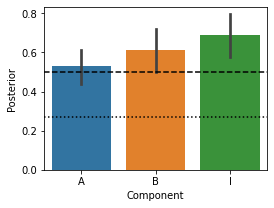

In [27]:

# Component posterior
plt.figure(figsize=(4,3))
cposterior = MF.component_posterior(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(cposterior,type='posterior')


#### Component Bayes factor 
For frequentist statistical testing and display, it is also often useful use the log-odds of the posterior $log(p/(1-p))$. For a flat prior across the model family, this is the bayes factor for the specific component. 

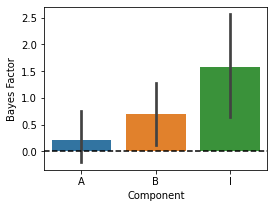

In [43]:
# Component Bayes Factor 
plt.figure(figsize=(4,3))
c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(c_bf,type='bf')

In [1]:
# show the second moment matrices
for i in range(3):
    plt.subplot(1,3,i)
    plt.imshow(M[i].G)

NameError: name 'plt' is not defined

Nice - up to a scaling factor (Subject 4 has especially high signal-to-noise) all seven subjects have a very similar structure of the reresentation of fingers in M1.  

If you are more used to looking in representational dissimilarity matrices (RDMs), you can also transform the second momement matrix into this (see Diedrichsen & Kriegeskorte,2017)

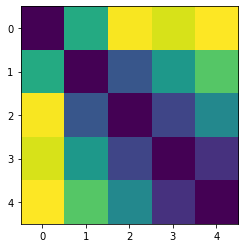

In [17]:
from scipy.spatial.distance import squareform
C = pcm.pairwise_contrast(np.arange(5))
RDM = squareform(np.diag(C @ G_hat[0,:,:]@C.T))
plt.imshow(RDM)

## Build the models
Now we are building a list of models, using a list of second moment matrices

In [18]:
# Make an empty list
M = []
# Null model: All fingers are represented independently. 
# For RSA model that would mean that all distances are equivalent
M.append(pcm.FixedModel('null',np.eye(5)))
# Muscle model: Structure is given by covariance structure of EMG signals
M.append(pcm.FixedModel('muscle',modelM[0]))
# Usage model: Structure is given by covariance structure of EMG signals
M.append(pcm.FixedModel('usage',modelM[1]))
# Component model: Linear combination of the muscle and usage model
M.append(pcm.ComponentModel('muscle+usage',[modelM[0],modelM[1]]))
# Free noise ceiling model
M.append(pcm.FreeModel('ceil',5)) # Noise ceiling model 

Now let's look at two underlying second moment matrices - these are pretty similar

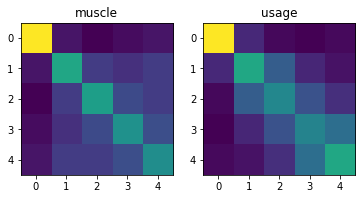

## Model fitting
Now let's fit the models to individual data set. There are three ways to do this. We can fit the models

* to each individual participant with it's own parameters $\theta$
* to each all participants together with shared parameters, but with an individual parameter for the signal strength and for group. 
* in a cross-participant crossvalidated fashion. The models are fit to N-1 subjects and evaluated on the Nth subject. 



In [20]:
# Do the individual fits - suppress verbose printout
T_in, theta_in = pcm.fit_model_individ(Y,M,fit_scale = True, verbose = False) 

In [22]:
# Fit the model in to the full group, using a individual scaling parameter for each 
T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4


In [23]:
# crossvalidated likelihood 
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4


## Inspecting and interpreting the results
The results are returned as a nested data frame with the likelihood, noise and scale parameter for each individuals

In [24]:
T_in

variable    likelihood                                            \
model             null        muscle         usage  muscle+usage   
0        -42231.412711 -41966.470799 -41786.672956 -41786.672927   
1        -34965.171104 -34923.791342 -34915.406608 -34914.959612   
2        -34767.538097 -34679.107626 -34632.643241 -34632.642946   
3        -45697.970627 -45609.052395 -45448.518276 -45448.518254   
4        -31993.363827 -31866.288313 -31806.982719 -31806.982521   
5        -41817.234010 -41632.061473 -41543.438786 -41543.438769   
6        -50336.142592 -50201.799362 -50173.300358 -50173.300306   

variable                   noise                                             \
model             ceil      null    muscle     usage muscle+usage      ceil   
0        -41689.860467  0.875853  0.871286  0.868482     0.868483  0.872297   
1        -34889.042762  1.070401  1.067480  1.069075     1.068119  1.066987   
2        -34571.750931  1.026408  1.021219  1.019122     1.019123  1.023299   
3        -45225.784824  1.480699  1.479592  1.474026     1.474025  1.478701   
4        -31707.184233  0.808482  0.805621  0.805774     0.805774  0.807319   
5        -41439.111953  1.035696  1.031827  1.031649     1.031648  1.034879   
6        -50099.140706  1.479001  1.472401  1.474430     1.474428  1.476145   

variable iterations                                     scale            \
model          null muscle usage muscle+usage  ceil      null    muscle   
0               4.0    4.0   4.0          7.0  30.0  0.109319  0.750145   
1               4.0    4.0   4.0         16.0  21.0  0.045008  0.324407   
2               4.0    4.0   4.0          7.0  32.0  0.059863  0.435483   
3               4.0    4.0   4.0          6.0  18.0  0.173031  1.193770   
4               4.0    4.0   4.0          6.0  32.0  0.073935  0.516338   
5               4.0    4.0   4.0          5.0  19.0  0.116696  0.801114   
6               4.0    4.0   4.0         12.0  29.0  0.101477  0.714043   

variable                                   
model        usage muscle+usage      ceil  
0         0.786771     1.000000  0.996839  
1         0.322917     0.963006  0.998003  
2         0.463987     1.000000  0.992453  
3         1.235628     1.000000  0.998176  
4         0.532421     1.000000  0.999360  
5         0.828773     1.000000  0.999325  
6         0.723969     1.000000  0.981997

The likelihoods are very negative and quite different across participants, which is expected (see documentation). What we need to interpret are the difference is the likelihood relative to a null model. 
We can visualized these using the model_plot

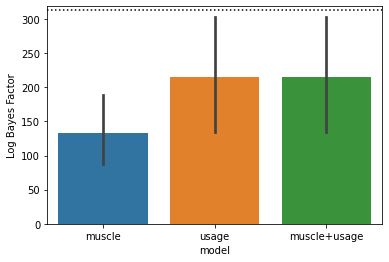

In [25]:
ax = pcm.model_plot(T_in.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil')

The problem with the noise ceiling is that it is individually fit to each subject. It has much more parameters than the models it is competing against, so it is overfitting. To compare models with different numbers of parameters directly, we need to look at our cross-validated group fits. The group fits can be used as an upper noise ceiling.

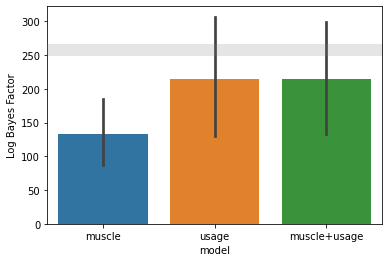

In [26]:
ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null',
                        noise_ceiling= 'ceil',
                        upper_ceiling = T_gr.likelihood['ceil'])


As you can see, the likelihood for individual, group, and crossvalidated group fits for the fixed models (null, muscle + usage) are all identical, because these models do not have common group parameters - in all cases we are fitting an individual scale and noise parameter. 

## Visualizing the model fit

Finally, it is very useful to visualize the model prediction in comparision to the fitted data. The model parameters are stored in the return argument `theta`. We can pass these to the `Model.predict()` function to get the predicted second moment matrix. 

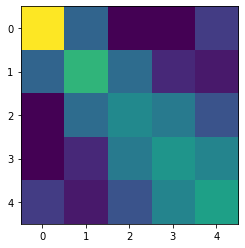

In [27]:
G,_ = M[4].predict(theta_gr[4][:M[4].n_param])
plt.imshow(G)